# CHAPTER 5 - Propagation Simulation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftshift, fftfreq, fft2, ifft2, ifftshift

# Define the rect function
def rect(x):
    return np.where(np.abs(x) <= 0.5, 1, 0)

def comb(x):
    # Dirac delta approximation: 1 where x is an integer, 0 otherwise
    return np.where(np.abs(x - np.round(x)) < 3e-2, 1, 0)

def circ_(x, y, r):
    return np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def sinc(x):
    return np.where(x == 0, 1, np.sin(x) / x)

def triangle(x):
    return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)

def gauss(x):
    return np.exp(-x**2)

def circ(r):
    return lambda x, y: np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

## 5.1 Fresnel Transfer Function (TF) Propagator

For Equation 5.1
$$
U_2(x,y) = \mathcal{F}^{-1} \left\{ \mathcal{F}\{U_1(x,y)\} H(f_x, f_y) \right\}
$$

For Equation 5.2
$$
H(f_x, f_y) = e^{ikz} \exp\left[-j\pi\lambda z (f_x^2 + f_y^2)\right]
$$


In [ ]:
def propTF(u1, L, lamda, z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    fx = np.linspace(-M/(2*L), M/(2*L), M) ; fy = fx
    FX, FY = np.meshgrid(fx, fy)


    H = np.exp(-1j* np.pi * lamda * z * (FX **2 + FY **2))
    H = fftshift(H)
    U1 = fft2(fftshift(u1))
    U2 = H* U1
    u2 = ifftshift(ifft2(U2))
    return u2

## 5.2 Fresnel Impulse Response (IR) Propagator

For Equation 5.3

$$
U_2(x,y) = \mathcal{S}^{-1} \left\{ \mathcal{S}\{U_1(x, y)\} \mathcal{S}\{h(x, y)\} \right\}
$$

For Equation 5.4

$$
h(x, y) = \frac{e^{ikz}}{j\lambda z} \exp\left[\frac{jk}{2z} (x^2 + y^2)\right]
$$


In [ ]:
def propIR(u1,L,lamda,z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    x = np.linspace(-L/2, L/2, M) ; y = x
    X, Y = np.meshgrid(x, y)

    h = 1 / (1j * lamda * z) * np.exp(1j * k / (2 * z) * (X ** 2 + Y ** 2))
    H = fft2(fftshift(h)) * dx ** 2
    U1 = fft2(fftshift(u1))
    U2 = H*U1
    u2 = ifftshift(ifft2(U2))

    return u2



## 5.3 Square Beam Example

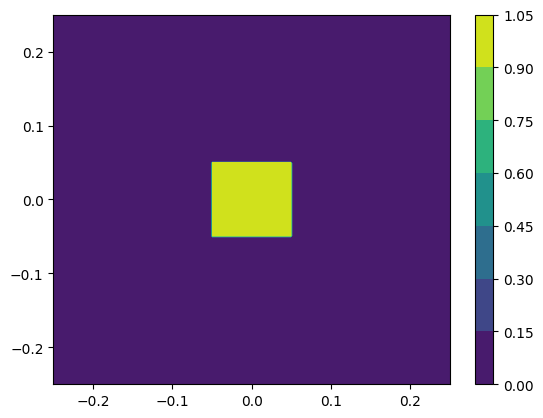

In [ ]:
L1 = 0.5
M = 250
dx1 = L1/M
x1 = np.linspace(-L1/2, L1/2, M) ; y1 = x1
lamda = 0.5e-6

k=2*  np.pi/lamda
w=0.051
z=2000

X1,Y1 = np.meshgrid(x1,y1)

u1= rect(X1/(2*w)) * rect(Y1/(2*w))
I1=abs(u1 ** 2)

plt.contourf(x1,y1,I1)
plt.colorbar()
plt.show()


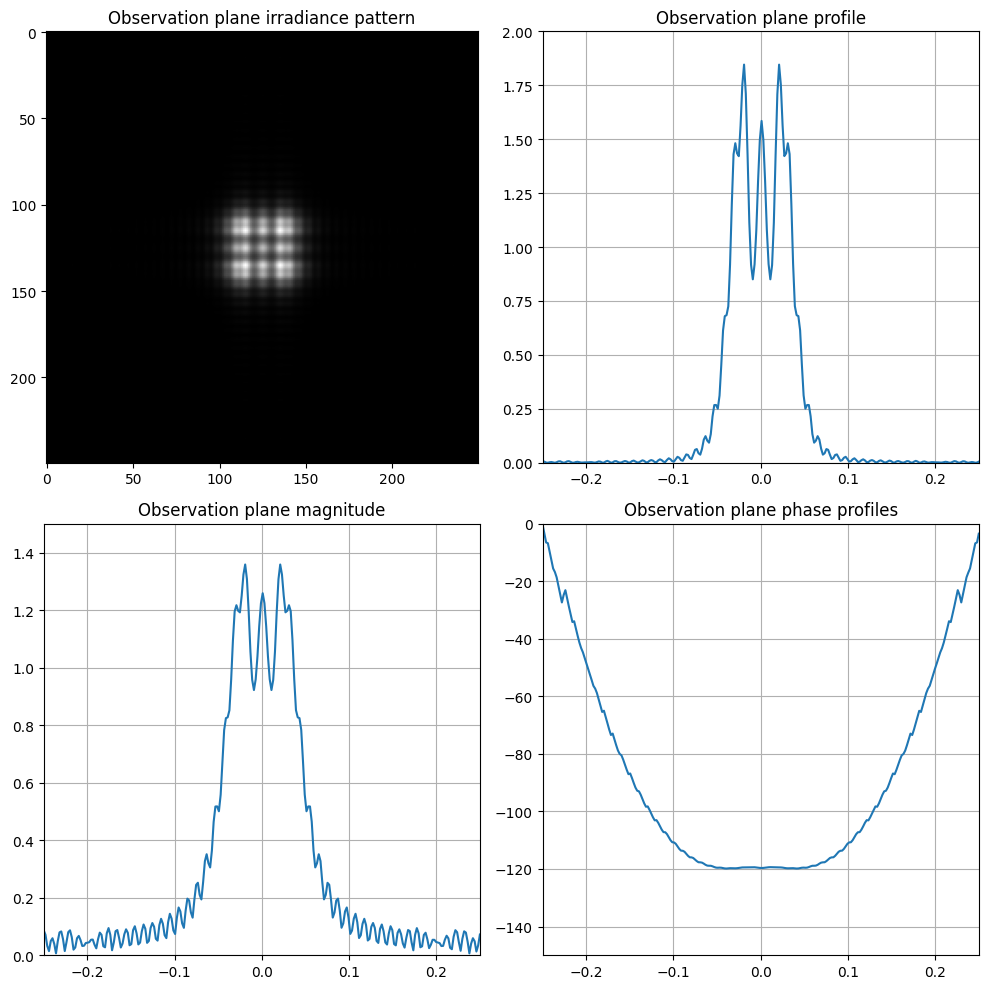

In [ ]:
z = 2000
u2 = propTF(u1, L1, lamda, z)
x2 = x1
y2 = y1
I2 = abs(u2 ** 2)

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid of subplots

# Top-left subplot: Contour plot of the irradiance pattern
contour = axs[0, 0].imshow(I2,cmap='gray') #contourf(x1, y1, I2, cmap='gray')
axs[0, 0].set_title('Observation plane irradiance pattern')

# Top-right subplot: Plot of the central horizontal slice of I2
axs[0, 1].plot(x1, I2[int(M/2) +1, :])
axs[0, 1].grid(True)
axs[0, 1].set_title('Observation plane profile')
axs[0, 1].set_xlim([-0.25, 0.25])
axs[0, 1].set_ylim([0, 2])

# Bottom-left subplot: Plot of the magnitude of the central horizontal slice of u2
axs[1, 0].plot(x2, np.abs(u2[int(M/2) + 1, :]))
axs[1, 0].grid(True)
axs[1, 0].set_title('Observation plane magnitude')
axs[1, 0].set_xlim([-0.25, 0.25])
axs[1, 0].set_ylim([0, 1.5])

# Bottom-right subplot: Unwrapped phase of the central horizontal slice of u2
axs[1, 1].plot(x2, np.unwrap(np.angle(u2[int(M/2) + 1, :])))
axs[1, 1].grid(True)
axs[1, 1].set_title('Observation plane phase profiles')
axs[1, 1].set_xlim([-0.25, 0.25])
axs[1, 1].set_ylim([-150, 0])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


## 5.4 Fresnel Propagation Sampling

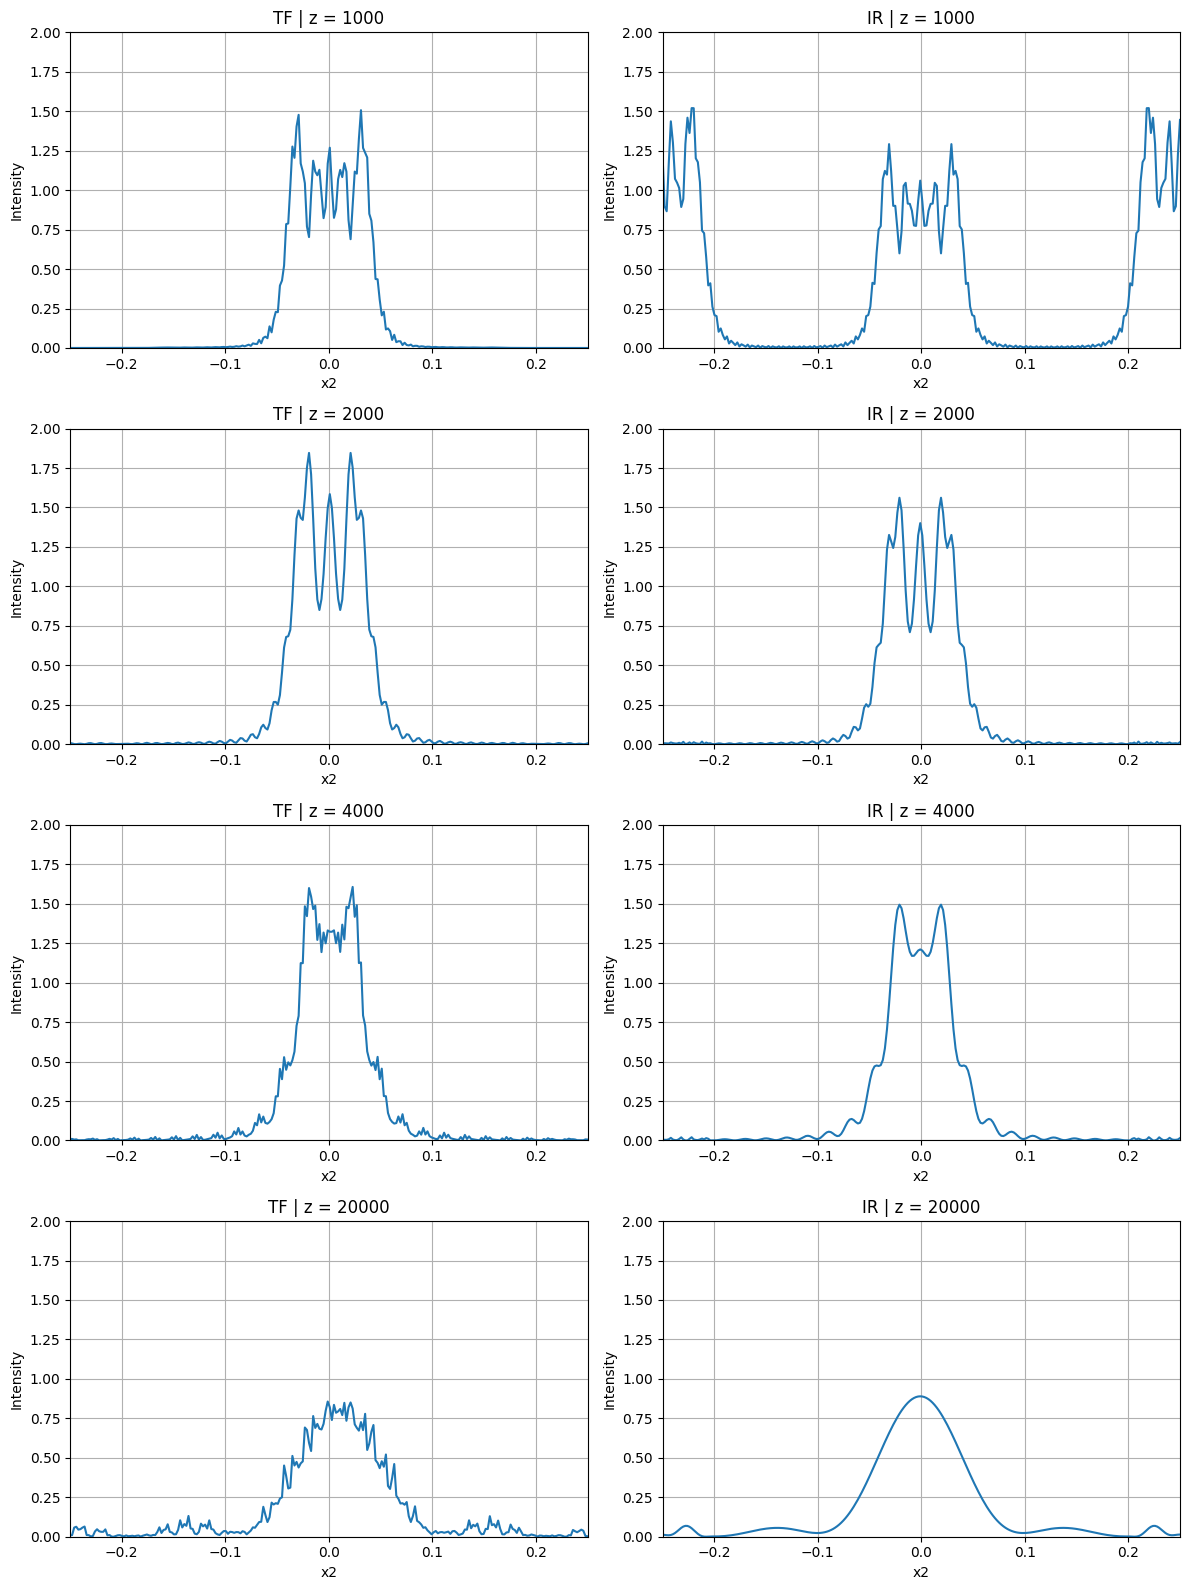

In [ ]:
z_values = [1000, 2000, 4000, 20000]
rows = len(z_values)  # two rows of plots
cols = 2  # each column is a different z value

fig, axs = plt.subplots(rows, cols, figsize=(12, 16))

for i, z in enumerate(z_values):
    L1 = 0.5
    # Compute the fields and intensities for impulse response
    u2_ir = propIR(u1, L1, lamda, z)
    I2_ir = np.abs(u2_ir**2)

    # Compute the fields and intensities for transfer function
    u2_tf = propTF(u1, L1, lamda, z)
    I2_tf = np.abs(u2_tf**2)

    # Plotting the impulse response
    axs[i, 1].plot(x1, np.abs(u2_ir[int(M/2) + 1, :])**2)
    axs[i, 1].grid(True)
    axs[i, 1].set_title(f'IR | z = {z}')
    axs[i, 1].set_xlabel('x2')
    axs[i, 1].set_ylabel('Intensity')
    axs[i, 1].set_xlim([-0.25, 0.25])  # Set x-axis limits
    axs[i, 1].set_ylim([0, 2])  # Set y-axis limits

    # Plotting the transfer function response
    axs[i, 0].plot(x1, np.abs(u2_tf[int(M/2) + 1, :])**2)
    axs[i, 0].grid(True)
    axs[i, 0].set_title(f'TF | z = {z}')
    axs[i, 0].set_xlabel('x2')
    axs[i, 0].set_ylabel('Intensity')
    axs[i, 0].set_xlim([-0.25, 0.25])  # Set x-axis limits
    axs[i, 0].set_ylim([0, 2])  # Set y-axis limits

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()




**Figure 5.4** Irradiance profiles (x axis) for the transfer function (TF) and impulse response
(IR) propagation approaches for propagation distances ranging from 1000 to 20,000 m.
“Spiky” and “stair-step” artifacts appear in (c) and (d); periodic copies appear in (e); and
spurious sidelobes appear in (h).


## 5.5 Fraunhofer Propagation

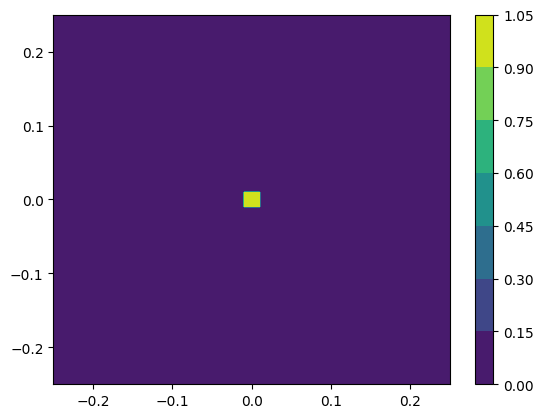

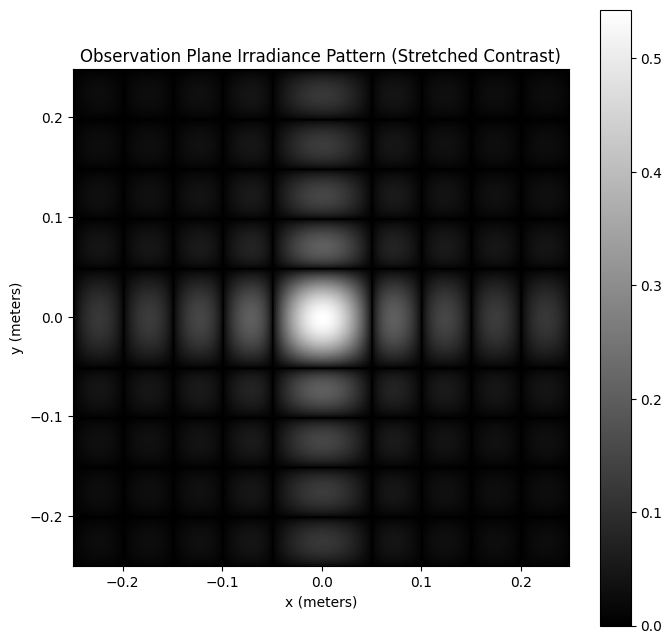

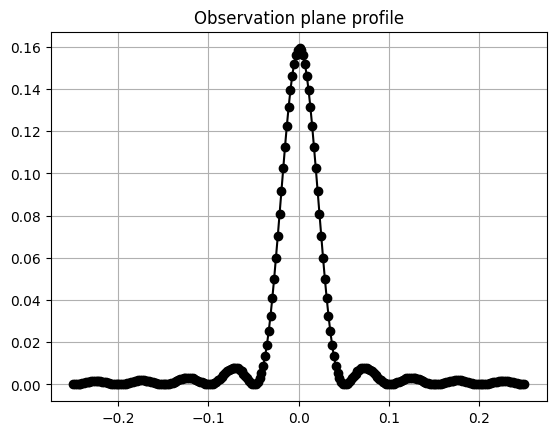

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def propFF(u1, L1, lambda_, z):
    """
    Propagation - Fraunhofer pattern
    Assumes uniform sampling

    Parameters:
    u1 : ndarray - Source plane field
    L1 : float - Source plane side length
    lambda_ : float - Wavelength
    z : float - Propagation distance

    Returns:
    u2 : ndarray - Observation plane field
    L2 : float - Observation plane side length
    """
    M, N = u1.shape  # Get input field array size
    dx1 = L1 / M  # Source sample interval
    k = 2 * np.pi / lambda_  # Wavenumber

    L2 = lambda_ * z / dx1  # Observation side length
    dx2 = lambda_ * z / L1  # Observation sample interval
    x2 = np.arange(-L2 / 2, L2 / 2, dx2)  # Observation coordinates

    X2, Y2 = np.meshgrid(x2, x2)  # Create 2D grid of observation coordinates
    c = 1 / (1j * lambda_ * z) * np.exp(1j * k / (2 * z) * (X2**2 + Y2**2))
    u2 = c * np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(u1))) * dx1**2

    return u2, L2

L1 = 0.5
M = 250
dx1 = L1/M
x1 = np.linspace(-L1/2, L1/2, M) ; y1 = x1
lamda = 0.5e-6

k=2*  np.pi/lamda
w=0.011
z=2000

X1,Y1 = np.meshgrid(x1,y1)

u1= rect(X1/(2*w)) * rect(Y1/(2*w))
I1=abs(u1 ** 2)

plt.contourf(x1,y1,I1)
plt.colorbar()
plt.show()


u2, L2 = propFF(u1, L1, lamda, z)
dx2 = L2 / M
x2 = np.arange(-L2 / 2, L2 / 2, dx2)  # Observation coordinates
y2 = x2

# Visualization
I2 = np.abs(u2)**2  # Intensity at the observation plane
plt.figure(figsize=(8, 8))
plt.imshow(np.power(I2, 1/3), extent=(x2[0], x2[-1], y2[0], y2[-1]), cmap='gray')
plt.colorbar()
plt.title('Observation Plane Irradiance Pattern (Stretched Contrast)')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.show()


# Top-right subplot: Plot of the central horizontal slice of I2
plt.plot(x1, I2[int(M/2) +1, :],"-ok")
plt.grid(True)
plt.title('Observation plane profile')
plt.show()

